<a href="https://colab.research.google.com/github/nzhinusoftcm/review-on-collaborative-filtering/blob/master/6.%20neural%20networks%20matrix%20factorization.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Neural Networks Matrix Factorization

Neural Networks can be applied to Matrix Factorization. Two predominent works on neural networks based matrix factorization are Neural Networks Matrix Factorization (NNMF) [Dziugaite and Roy 2015](https://arxiv.org/abs/1511.06443) and  Neural Collaborative Filtering (NFC) [Xiangnan He et al, 2017](https://arxiv.org/abs/1708.05031).

--- 
### How to desing Matrix Factorization with Neural Networks ?

Matrix Factorization (**Figure 1 Left**) decomposes the rating matrix $R$ by

\begin{equation}
R = Q^{\top}P,
\end{equation}

Where $P$ and $Q$ are latent factors of users and items respectively, and the rating prediction for user $u$ on item $i$ is given by $\hat{R}_{u,i} = Q_{i}^{\top}P_u$. Instead of decomposing $R$ into $P$ and $Q$, neural networks model the two-way interaction between users and items through their hidden layers. **Figure 1 Right** presents an example of hidden representations of latent factors $P$ and $Q$.

The neural network model is designed as follow : 

1. Two inputs $(u,i)$ : (<b>userid</b>,<b>itemid</b>); It takes a user and an item in its input layer
2. One output $\hat{r}$ : <b>predicted rating</b>); Return the predicted rating of the input user on the input item.

Training examples are the set of $(u,i)$ pairs for which the ratings are known and training labels are the set of known ratings $r_{u,i}$. Training examples are represented as $((u,i), r)$; where $(u,i)$ is one training example and $r$ is the corresponding training label

![](tools/img/MF-and-NNMF.png)
<br>
<center><b>Figure 1</b>: <b>Left</b> Matrix Factorization, <b>Right</b> Neural Network Based MF </center>

---
### Details implementation

To implement the neural network based matrix factorization, we will proceed as follows 

1. Data preprocessing : encode users and items ids, split data into train and test sets
2. Model building : build the matrix factorization model using neural networks
3. Training

Let's start by importing requirements

In [1]:
import os

if os.path.exists("tools.zip") or os.path.exists("tools"):
    print('[INFO] Tools already exist')
else:
    print('[INFO] Download tools ...')
    !wget https://www.dropbox.com/s/fm1zn2bf08lgnun/tools.zip
    
    print('[INFO] unzip downloaded tools ...')    
    !unzip tools.zip

[INFO] Tools already exist


## Import requirements

In [2]:
from tools.utils import download_data, load_movies, load_ratings
from tools.preprocessing import split_data, encode_data

import tensorflow as tf
import pandas as pd
import numpy as np

Download movielen data if it doesn't exist

In [3]:
data = os.path.join('tools', 'ml-latest-small')

if os.path.exists(data):
    print('Data already exists ...')
    ratings_csv, movies_csv = os.path.join(data, 'ratings.csv'), os.path.join(data, 'movies.csv')
else:
    ratings_csv, movies_csv = download_data()

Data already exists ...


## Loading dataset

In [4]:
ratings, movies = load_ratings(ratings_csv), load_movies(movies_csv)

m = len(ratings.userid.unique())   # total number of users
n = len(ratings.itemid.unique())    # total number of items

## Preprocess data

---
### train test split

In [5]:
examples, labels = split_data(ratings, test_size=0.1)

[INFO] Train/Test split 
  -  90.0 % of training data
  -  10.0 % of testing data

number of training examples :  (90752, 2)
number of training labels :  (90752,)
number of test examples :  (10084, 2)
number of test labels :  (10084,)


### Encode users and items id

In [6]:
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data(ratings, examples, labels)

## Model building

Let's now build the Matrix Factorization Model. To model matrices $P$ and $Q$, we will use the ```Embedding``` layer of the ```keras``` library

In [7]:
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2

K = tf.keras.backend

def NNMF(m, n, k=50):
    """
    The matrix factorization model takes two inputs : 
        - input_user : one-hot representation of user id
        - input_item : one-hot representation of item id
        
    :param
        - m : number of users
        - n : number of items
        - k : number of factors to model for both users (P) and items (Q)
    """
    # modeling inputs
    input_user = Input(shape=(1,), name='input_user')
    input_item = Input(shape=(1,), name='input_item')
    
    # modeling latent factors of users of items
    P = Embedding(m, k, embeddings_initializer="random_normal", name='users_factors')(input_user)
    Q = Embedding(n, k, embeddings_initializer="random_normal", name='items_factors')(input_item)

    # Flatten latent factors
    P = Flatten(name='Flatten_P')(P)
    Q = Flatten(name='Flatten_Q')(Q)
    
    # dot product between P and Q to make prediction
    r_hat = Dot(axes=(1))([P,Q])
    
    model = Model(inputs=[input_user, input_item], outputs=r_hat)
    
    return model

In [8]:
model = NNMF(m, n, k=30)
epochs = 5

Now, we can compile and train the model 

In [9]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [10]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
2836/2836 [==============================] - 13s 5ms/step - loss: 10.1330 - mae: 2.9132 - val_loss: 3.6891 - val_mae: 1.5645
Epoch 2/5
2836/2836 [==============================] - 12s 4ms/step - loss: 2.1864 - mae: 1.1289 - val_loss: 1.7048 - val_mae: 0.9565
Epoch 3/5
2836/2836 [==============================] - 11s 4ms/step - loss: 1.2011 - mae: 0.8160 - val_loss: 1.3794 - val_mae: 0.8448
Epoch 4/5
2836/2836 [==============================] - 11s 4ms/step - loss: 0.9214 - mae: 0.7232 - val_loss: 1.2778 - val_mae: 0.8092
Epoch 5/5
2836/2836 [==============================] - 11s 4ms/step - loss: 0.7757 - mae: 0.6700 - val_loss: 1.2461 - val_mae: 0.8012


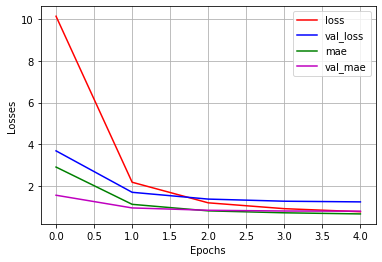

In [11]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, epochs), history.history['loss'], 'r', label="loss")
plt.plot(np.arange(0, epochs), history.history['val_loss'], 'b', label="val_loss")
plt.plot(np.arange(0, epochs), history.history['mae'], 'g', label="mae")
plt.plot(np.arange(0, epochs), history.history['val_mae'], 'm', label="val_mae")
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid(True)
plt.show()

Model evaluation

In [12]:
model.evaluate(X_test, y_test, verbose=1)

316/316 [==============================] - 0s 543us/step - loss: 1.2461 - mae: 0.8012


[1.246104121208191, 0.8011568188667297]

---
### How to make recommendation ?

As Matrix Factorization models the rating matrix $R$ as

\begin{equation}
R = Q^{\top}P
\end{equation}

To predict what score user $u$ will have given to item $i$, we multiply the $u^{th}$ row of $P$ and the $i^{th}$ row of $Q$ as follows :

\begin{equation}
\hat{R}_{u,i} = Q_{i}^{\top}P_{u}
\end{equation}

Here, $Q_i$ is the $i^{th}$ row of $Q$ and $P_u$ is the $u^{th}$ row of $P$.

In order to acheive these predictions, let's get the learnt embeddings $P$ and $Q$ from the NNMF model

In [13]:
# get embeddings of users
P = model.get_layer(name='users_factors').get_weights()[0]

# get embeddings of items
Q = model.get_layer(name='items_factors').get_weights()[0]

Now, let's make recommendations for a given user $u=15$ and item $i=48516$

In [14]:
def predict(userid, itemid):
    """
    predict the 
    """

    # encode user and item ids
    userid = uencoder.transform([userid])
    itemid = iencoder.transform([itemid])

    # prediction
    r = Dot(axes=1)([P[userid],Q[itemid]])[0]

    return np.array(r)[0]

In [15]:
predict(userid=15, itemid=48516)

3.578427

## Reference

1. Dziugaite and Roy (2015), [Neural Network Matrix Factorization](https://arxiv.org/abs/1511.06443)
2. Xiangnan He et al (2017), [Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031)

## Author

<a href="https://www.linkedin.com/in/carmel-wenga-871876178/">Carmel WENGA</a>, Applied Machine Learning Research Engineer | <a href="https://shoppinglist.cm/fr/">ShoppingList</a>, Nzhinusoft